In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from anndata import read_h5ad
import abc_load
import ccf_registration as ccf



In [3]:
df_full = abc_load.get_combined_metadata(cirro_names=False, version="20230830")


In [5]:
df_neuronal = df_full.loc[lambda df: df['class'].str.contains('Glut') | 
                df['class'].str.contains('GABA')]
adata_ref = read_h5ad(abc_load._THALAMUS_ANNDATA_PATH, backed='r')
ref_index = adata_ref.obs_names.intersection(df_neuronal.index)

In [9]:
th_frac = df_neuronal.groupby('subclass', observed=True).apply(lambda x: len(x.index.intersection(ref_index))/len(x))

th_frac2 = df_neuronal.groupby('subclass', observed=True).apply(lambda x: ((x['parcellation_division'] == 'TH') |
                                                 (x['parcellation_structure'] == 'ZI')).sum() / len(x))

In [10]:
th_frac.sort_values(ascending=False).head(20)

subclass
150 CM-IAD-CL-PCN Sema5b Glut             0.999714
151 TH Prkcd Grin2c Glut                  0.997257
148 AV Col27a1 Glut                       0.995354
147 AD Serpinb7 Glut                      0.993277
152 RE-Xi Nox4 Glut                       0.992487
149 PVT-PT Ntrk1 Glut                     0.988044
145 MH Tac2 Glut                          0.984242
146 LH Pou4f1 Sox1 Glut                   0.983130
154 PF Fzd5 Glut                          0.967882
153 MG-POL-SGN Nts Glut                   0.965432
109 LGv-ZI Otx2 Gaba                      0.962536
093 RT-ZI Gnb3 Gaba                       0.910603
101 ZI Pax6 Gaba                          0.734139
110 BST-po Iigp1 Glut                     0.703297
203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba      0.598144
168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut    0.486436
103 PVHd-DMH Lhx6 Gaba                    0.225472
096 PVHd Gsc Gaba                         0.204082
167 PRC-PAG Tcf7l2 Irx2 Glut              0.200782
097 PVHd-SBPV Six3 Pro

In [11]:
th_subclasses = th_frac.loc[lambda x: x>0.33].index
th_subclasses2 = th_frac2.loc[lambda x: x>0.33].index
th_subclasses.equals(th_subclasses2)

True

In [12]:
th_subclasses

CategoricalIndex(['168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', '101 ZI Pax6 Gaba',
                  '109 LGv-ZI Otx2 Gaba', '093 RT-ZI Gnb3 Gaba',
                  '149 PVT-PT Ntrk1 Glut', '151 TH Prkcd Grin2c Glut',
                  '152 RE-Xi Nox4 Glut', '154 PF Fzd5 Glut',
                  '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba',
                  '148 AV Col27a1 Glut', '146 LH Pou4f1 Sox1 Glut',
                  '147 AD Serpinb7 Glut', '153 MG-POL-SGN Nts Glut',
                  '110 BST-po Iigp1 Glut', '150 CM-IAD-CL-PCN Sema5b Glut',
                  '145 MH Tac2 Glut'],
                 categories=['009 L2/3 IT PIR-ENTl Glut', '036 HPF CR Glut', '037 DG Glut', '038 DG-PIR Ex IMN', ..., '260 MDRNv Crp Glut', '034 NP PPP Glut', '026 NLOT Rho Glut', '067 LSX Sall3 Pax6 Gaba'], ordered=False, dtype='category', name='subclass')

## Validation

In [4]:
coords_ccf = ['x_ccf', 'y_ccf', 'z_ccf']
coords_rec = ['x_reconstructed', 'y_reconstructed', 'z_reconstructed']
coords_sec = ['x_section', 'y_section', 'z_section']


In [ ]:

common_index = df_full.index.intersection(df_new.index)
(df_full.loc[common_index, coords_ccf+coords_from+img_coords] == 
 df_new.loc[common_index, coords_ccf+coords_from+img_coords]).all()


In [27]:
(df_full.loc[common_index, img_coords] != 
 df_new.loc[common_index, img_coords]).any(axis=1).mean()

0.5593320812492296

In [31]:
((df_full.loc[common_index, img_coords] - 
 df_new.loc[common_index, img_coords]).round(3) > 0).any(axis=1).mean()

0.0

In [38]:
t1 = ccf.get_ccf_transform(df_full, coords_from, coords_ccf)
t2 = ccf.get_ccf_transform(df_full, coords_from, coords_ccf)
np.abs(t1-t2)

array([[1.48645486e-04, 1.45394574e-03, 4.01610443e-05, 2.22044605e-16],
       [4.33532016e-04, 4.48342274e-04, 1.62545981e-02, 1.38777878e-15],
       [2.24738210e-04, 1.60088175e-03, 1.31316340e-02, 5.82867088e-16],
       [3.17304742e-04, 7.34315390e-03, 1.45347738e-02, 2.22044605e-16]])

In [86]:
from importlib import reload
reload(ccf)

<module 'ccf_registration' from '/root/capsule/code/ccf_registration.py'>

In [49]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy.linalg as linalg


In [79]:

df = df_full
coords_to = coords_ccf
coords_from = coords_rec
samples = np.random.randint(0, len(df), 200)
to = ccf.to_hom(df[coords_to].iloc[samples].values)
x, res, rank, s = linalg.lstsq(ccf.to_hom(df[coords_from].iloc[samples].values), 
             to)
    

In [80]:
res / (len(to)*np.var(to, axis=0))

/tmp/ipykernel_12799/4176339426.py:1: RuntimeWarning: divide by zero encountered in true_divide
  res / (len(to)*np.var(to, axis=0))


array([1.86539972e-08, 2.19633452e-06, 3.24436287e-06,            inf])

## CCF images

### old atlas nrrd to nifti

In [8]:
import nibabel as nib
import nrrd

In [9]:

# from http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/

# Get a list of .nrrd files in a directory
nrrd_file = '../data/annotation_10.nrrd'
# Read the .nrrd file
data, header = nrrd.read(nrrd_file)


In [10]:
data.dtype

dtype('uint32')

In [12]:
data2 = np.moveaxis(np.flip(np.flip(data, 0), 1), range(3), (1, 2, 0))

In [17]:
data2 = np.array(data2, dtype=np.dtype('<u4'))
data2.dtype

dtype('uint32')

In [14]:
np.array([456., 528., 320.])*2.5

array([1140., 1320.,  800.])

In [47]:
np.array(data2.shape)/2.5

array([456., 528., 320.])

In [ ]:
nifti_img.g

In [39]:
nifti_img = nib.Nifti1Image(data2, affine=np.eye(4))


In [42]:
# Save the NIfTI1Image object as .nii file
nib.save(nifti_img, '../data/labels.nii.gz')

In [19]:
im_path = "/data/labels.nii.gz"
img = nib.load(im_path)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [44]:
print(nifti_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [   3 1140 1320  800    1    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y          

In [ ]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 456 528 320   0   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y          : [0. 1.

In [27]:
img.shape

(456, 528, 320)

In [36]:
img.affine

array([[  -1. ,    0. ,    0. ,  227.5],
       [   0. ,    1. ,    0. , -263.5],
       [   0. ,    0. ,    1. , -159.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [28]:
img.header.get_zooms()

(1.0, 1.0, 1.0)

In [22]:
img.get_data_dtype()

dtype('<u4')

### Nibabel nii load from atlas

In [11]:
im_path = "/data/abc_atlas/image_volumes/Allen-CCF-2020/20230630/annotation_10.nii.gz"
img = nib.load(im_path)

In [13]:
img.shape

(1320, 800, 1140)

In [14]:
img.affine

array([[ 0.        ,  0.        ,  0.01      , -5.69500017],
       [-0.01      ,  0.        ,  0.        ,  5.3499999 ],
       [ 0.        , -0.01      ,  0.        ,  5.21999979],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [15]:
img.header.get_xyzt_units()

('mm', 'unknown')

### save new IDs / colors for visualign

In [1]:
import pandas as pd

In [7]:
parcellation = pd.read_csv("../data/allen-brain-cell-atlas/metadata/Allen-CCF-2020/20230630/parcellation_to_parcellation_term_membership.csv")

In [ ]:
cols = ['red','green','blue', 'parcellation_term_name']
old_atlas = lambda df: df.loc[df['parcellation_term_label'].str.contains('2017')]
pick_finest = lambda df: df.loc[df['term_set_order'] == df['term_set_order'].max()]
parcellation_finest = parcellation.groupby('parcellation_index').apply(pick_finest)

In [ ]:
parcellation_finest = parcellation.groupby('parcellation_index').apply(pick_finest)


In [26]:
parcellation.head()

,parcellation_label,parcellation_term_label,parcellation_term_set_label,parcellation_index,voxel_count,volume_mm3,color_hex_triplet,red,green,blue,parcellation_term_name,parcellation_term_acronym,parcellation_term_set_name,term_set_order,term_order,parent_term_label
0,AllenCCF-Annotation-2020-997,AllenCCF-Ontology-2017-997,AllenCCF-Ontology-2017-ORGA,987,3564320,3.56432,#FFFFFF,255,255,255,brain,brain,organ,0,0,NaN
1,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-997,AllenCCF-Ontology-2017-ORGA,63,256520,0.25652,#FFFFFF,255,255,255,brain,brain,organ,0,0,NaN
2,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-8,AllenCCF-Ontology-2017-CATE,63,256520,0.25652,#BFDAE3,191,218,227,Basic cell groups and regions,grey,category,1,1,AllenCCF-Ontology-2017-997
3,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-315,AllenCCF-Ontology-2017-DIVI,63,256520,0.25652,#70FF71,112,255,113,Isocortex,Isocortex,division,2,1,AllenCCF-Ontology-2017-8
4,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-184,AllenCCF-Ontology-2017-STRU,63,256520,0.25652,#268F45,38,143,69,"Frontal pole, cerebral cortex",FRP,structure,3,1,AllenCCF-Ontology-2017-315


## making subclass images

In [45]:

def preproc_data(df, nn_classes, img_coords, ref_spatial, ref_subset=None):
    # df = df_full.loc[lambda df: df[img_coords[0]].notna()]
    if ref_subset is None:
        ref_subset = ref_spatial
    df = ccf.subset_to_ref_bounds(df, img_coords, ref_spatial)
    ref_subset = df.index.intersection(ref_subset)
    
    slice_label = 'slice_int'
    df[slice_label] = df['z_section'].apply(lambda x: str(int(x*10)))

    working_label = "thal_class"
    img_label = 'subclass_int'
    df[working_label] = df["class"]
    df.loc[ref_subset, working_label] = df.loc[ref_subset, "subclass"]

    all_labels = df[working_label].unique()
    focus_labels = df.loc[ref_subset, working_label].value_counts().index
    other_labels = df.loc[df.index.difference(ref_subset)].loc[
        lambda df: ~df['class'].isin(nn_classes), working_label].value_counts().index

    label_order = [""] + list(focus_labels) + nn_classes + list(other_labels)
    label_map = {x: label_order.index(x) for x in all_labels}
    df[img_label] = df[working_label].map(label_map)
    cmap = ccf.cmap_with_emphasis(len(focus_labels), n_secondary=len(nn_classes))
    return df, cmap

In [30]:
slice_label = 'slice_int'

working_label = "thal_class"
img_label = 'subclass_int'

img_coords = ['x_section', 'y_section', 'z_section']
coords_from = ['x_reconstructed', 'y_reconstructed', 'z_reconstructed']

In [112]:
nn_classes = ["31 OPC-Oligo",
              "30 Astro-Epen",
              "33 Vascular",
              "34 Immune"]
df, cmap = preproc_data(df_full, nn_classes, img_coords, ref_index)
out = ccf.export_to_quicknii(df, 'brain3_20220830', cmap=cmap,
                       img_coords=img_coords, coords_from=coords_from,
                       img_label=img_label, slice_label=slice_label, scale=25,
                   path='../results/qn_25_affine_thal_focus_20220630', 
                   save_json=True, save_images=False)

In [39]:
nn_classes = ["31 OPC-Oligo",
              "30 Astro-Epen",
              "33 Vascular",
              "34 Immune"]
ref_subclasses = df_neuronal.loc[lambda df: df['subclass'].isin(th_subclasses)].index
df, cmap = preproc_data(df_full, nn_classes, img_coords, ref_index, ref_subclasses)


In [ ]:

out = ccf.export_to_quicknii(df, 'brain3_20220830', cmap=cmap,
                       img_coords=img_coords, coords_from=coords_from,
                       img_label=img_label, slice_label=slice_label, scale=25,
                   path='../results/qn_25_affine_thal_subclasses_20220630', 
                   save_json=True, save_images=True)

In [113]:
# old
nn_classes = [
    "28 Astro-Epen",
    "29 Oligo",
    "31 Vascular",
    "32 Immune"
]
df, cmap = preproc_data(df_full, nn_classes, img_coords, ref_index)
out = ccf.export_to_quicknii(df, 'brain3_20220630_2', cmap=cmap,
                       img_coords=img_coords, coords_from=coords_from,
                       img_label=img_label, slice_label=slice_label, scale=25,
                   path='../results/qn_25_affine_thal_focus_20220630', 
                   save_json=True, save_images=False)

In [41]:
coords_from = ['x_reconstructed', 'y_reconstructed', 'z_reconstructed']
img_coords = ['x_section', 'y_section', 'z_section']
ccf.export_to_quicknii(df, 'brain3_20220630', cmap=cmap,
                       img_coords=img_coords, coords_from=coords_from,
                       img_label=img_label, slice_label=slice_label, scale=25,
                   path='../results/qn_25_affine_thal_focus_20220630', save_images=True);

In [ ]:
coords_from = ['x_reconstructed', 'y_reconstructed', 'z_reconstructed']
img_coords = ['x_section', 'y_section', 'z_section']
ccf.export_to_quicknii(df, 'brain3', cmap=cmap,
                       img_coords=img_coords, coords_from=coords_from,
                       img_label=img_label, slice_label=slice_label, scale=25,
                   path='../results/qn_25_affine_thal_focus', save_images=True);

In [10]:
nn_classes = ["31 OPC-Oligo",
              "30 Astro-Epen",
              "33 Vascular",
              "34 Immune"]
df, cmap = preproc_data(df_full, nn_classes, img_coords, ref_index)
img_coords = ['x_reconstructed', 'y_reconstructed', 'z_reconstructed']
ccf.export_to_quicknii(df, 'brain3_subclass', cmap=cmap, img_coords=img_coords, img_label=img_label, slice_label=slice_label, scale=25,
                   path='../results/qn_25_reconstructed', save_images=True);

In [8]:
img_coords = ['x_reconstructed', 'y_reconstructed', 'z_reconstructed']
df[img_coords].agg(['min','max'])

,x_reconstructed,y_reconstructed,z_reconstructed
min,2.426030,-7.499979,4.8
max,8.517774,-3.210131,8.2


In [ ]:
df[img_coords].agg(['min','max'])

,x_reconstructed,y_reconstructed,z_reconstructed
min,2.534730,-6.979664,4.8
max,8.432556,-4.151366,8.2


In [9]:
df[['x_ccf', 'y_ccf', 'z_ccf']].agg(['min','max'])

,x_ccf,y_ccf,z_ccf
min,5.569296,1.545035,2.557311
max,9.236765,6.344886,8.733679


In [ ]:
df[['x_ccf', 'y_ccf', 'z_ccf']].agg(['min','max'])

,x_ccf,y_ccf,z_ccf
min,5.708132,2.564785,2.646385
max,9.022550,5.734146,8.667240


In [14]:
img_coords = ['x_reconstructed', 'y_reconstructed', 'z_reconstructed']
dfslice = df.query("brain_section_label=='C57BL6J-638850.43'").copy()

In [39]:
dfimg, coords_scaled, coords_int = ccf.add_rescaled_coords(dfslice, img_coords[:2], xy_res=0.0025,
                                                    ref_subset=ref_index.intersection(dfslice.index))


In [37]:
nx, ny = dfimg[coords_int].max() + 1
(nx, ny)

(1700, 946)

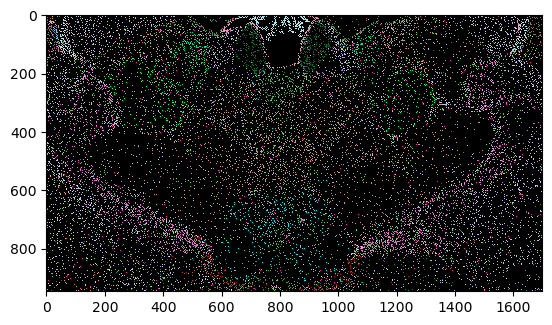

In [40]:
img = ccf.rasterize_by_dilation(dfimg, coords_int, label=img_label, shape=(ny, nx))

plt.imshow(img, cmap=ccf.CMAP, interpolation='nearest')
# plt.imsave("test.tiff", img.T, cmap=cmap)
plt.show()

In [21]:
df = adata.obs
# add_rescaled_coords(df, xy_res=0.0025)
x, y, z = ('x', 'y', 'z_reconstructed')
to_ccf = get_ccf_transform(df, (x,y,z))

In [26]:
z = 7.8
origin = np.array([[0, 1, z]])
origin_ccf = np.matmul(to_hom(origin), to_ccf)
origin_ccf

array([[6.27002936, 2.43664137, 2.68422409, 1.        ]])

In [35]:
origin_qn = np.matmul(origin_ccf, ccf_to_qn)
origin_qn

array([[107.36896349, 276.19882574, 221.53434523,   1.        ]])

In [83]:
np.linalg.inv(np.array([[1, 0, 1], [0, 1, 1], [0, 0, 1]]))

array([[ 1.,  0., -1.],
       [ 0.,  1., -1.],
       [ 0.,  0.,  1.]])